# Group Project Report

## Introduction

Heart disease is increasingly common and one of the leading causes of death around the world. As algorithms and modeling become more accessible and sophisticated, they can be used to predict and diagnose heart disease. Here, we will create a simple model using the k-nearest neighbors algorithm to predict whether the patient has the symptoms of chest pain in individuals testing for heart disease. We will investigate how accurately we can predict the occurrence of chest pain with a K-nearest Neighbor model? 

The dataset we will use is called “processed.cleveland.data” from the Machine Learning Repository. Data was collected between May 1981 and September 1984 and stems from the angiography results of 303 patients at the Cleveland Clinic in Cleveland, Ohio. The average age of study participants was 54 and 206 of the 303 participants were men (“International application of a new probability algorithm”). Similar algorithms have been created like the one described in Detrano et al.’s International Application of a New Probability Algorithm for the Diagnosis of Coronary Artery Disease where the same data set, along with similar ones, trained an algorithm to predict heart disease. 

## Methods and Results

As mentioned previously, we will develop a model using this dataset to predict the patient’s chance of experiencing chest pain. The potential types of chest pain are typical angina, atypical angina, non-anginal pain, and asymptomatic pain. Our model will use the k-nearest neighbors algorithm and consider age, sex, electrocardiogram rate at rest (restecg), systolic blood pressure (trestbps), and cholesterol (chol) as variables. Age and sex were chosen because women report a greater risk of developing CVD than men of the same age group; however, the risk of developing CVD increases with age in both sexes (Rodgers et al., 2019). The American Heart Association reported that in the US, the likelihood of developing CVD for men and women between the ages of 40-59 is ~40%, between 60-79 years is ~75%, and above the age of 80, the likelihood increased to ~86%. By incorporating age and sex, we can better estimate an individual’s likelihood of developing CVD (Rodgers et al., 2019). The electrocardiogram at rest provides information about heart rate, rhythm, and potential heart enlargement, making it a useful tool for investigating symptoms (Electrocardiogram, 2023). The heart's activity is measured by electrical activity and the electrical impulse that travels through your heart (Electrocardiogram, 2023). The electrical passage can be tracked and used to determine whether the activity is regular or irregular. ECG is often used when experiencing chest pains, and the result can be correlated with numerous heart conditions (Electrocardiogram, 2023). Another factor we selected is blood pressure (BP). BP is one of the most important risk factors for CVD and the leading cause of mortality (Wu et al., 2015). Heart disease is associated with elevated systolic blood pressure, which damages arteries and impedes blood flow to the heart muscle. It is estimated that BP will affect 65% of the population for individuals over the age of 60 (Wu et al., 2015). Additionally, abnormal levels of serum cholesterol in the blood increase the risk of heart disease by promoting the development of fatty deposits in blood vessels, which can hinder flow through arteries (Carson, 2023). Although studies conducted do not indicate a strong association with CVD risk, it is still included as a variable due to the relationship of dietary cholesterol with heart health (Carson, 2023).


Let's load the important --- and set a seed so that the project is reproducible.

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

We need to first read the dataset from the internet. After reading the data, we can rename the columns to make the data more informative. This is done below:

In [2]:

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
cleveland_data <- read_csv(url, col_names = FALSE)
cleveland_data <- rename(cleveland_data,
       age = X1, 
       sex = X2, 
       cp = X3,
       trestbps = X4, 
       chol = X5, 
       fbs = X6, 
       restecg = X7, 
       thalach = X8, 
       exang = X9, 
       oldpeak = X10, 
       slope = X11, 
       ca = X12, 
       thal = X13, 
       num = X14)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The data is then mutated to convert the columns into the right variable type. For example, since cp(chest pain) is a factor, we can use the as_factor function to convert the column.

In [3]:

cd_mutate <- cleveland_data |>
mutate(cp = as_factor(cp)) 

The dataset for heart disease contains "?" instead of NA values which might be difficult to deal with later on. We can replace all the "?" to NA as shown below.

In [4]:

cd_mutate[cd_mutate == "?"] <- NA
cd_mutate <- filter(cd_mutate, ca != "NA")
cd_mutate <- mutate(cd_mutate, cp = ifelse((cp == 1| cp == 2 | cp ==3), 1, 0)) |>
            mutate(cp = as_factor(cp)) 
cd_mutate

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,0,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,0,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,1,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,1,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,1,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,0,140,268,0,2,160,0,3.6,3,2.0,3.0,3
57,0,0,120,354,0,0,163,1,0.6,1,0.0,3.0,0
63,1,0,130,254,0,2,147,0,1.4,2,1.0,7.0,2


For this model, we will be using the variables age, sex, chol, restecg, trestbps to predict the cp type. Hence, we should select these columns from the dataset. 

In [5]:

cd_select<-select(cd_mutate, age, chol, trestbps, cp)

We have cleaned and wrangled the data to give a tidy data frame. We can now proceed to split the data into training and testing sets to conduct the analysis.

In [6]:
set.seed(88)
cd_split<-initial_split(cd_select, prop=0.75, strata=cp)
cd_training<-training(cd_split)
cd_testing<-testing(cd_split)

Let's begin with choosing a K value

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.4811594,10,0.03699541,Preprocessor1_Model01
3,accuracy,binary,0.4668737,10,0.02320576,Preprocessor1_Model02
4,accuracy,binary,0.4668737,10,0.02320576,Preprocessor1_Model03
5,accuracy,binary,0.5124224,10,0.01846472,Preprocessor1_Model04
6,accuracy,binary,0.5124224,10,0.01846472,Preprocessor1_Model05
7,accuracy,binary,0.5623188,10,0.01646277,Preprocessor1_Model06
8,accuracy,binary,0.5623188,10,0.01646277,Preprocessor1_Model07
9,accuracy,binary,0.5801242,10,0.02220850,Preprocessor1_Model08
10,accuracy,binary,0.5801242,10,0.02220850,Preprocessor1_Model09


Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”


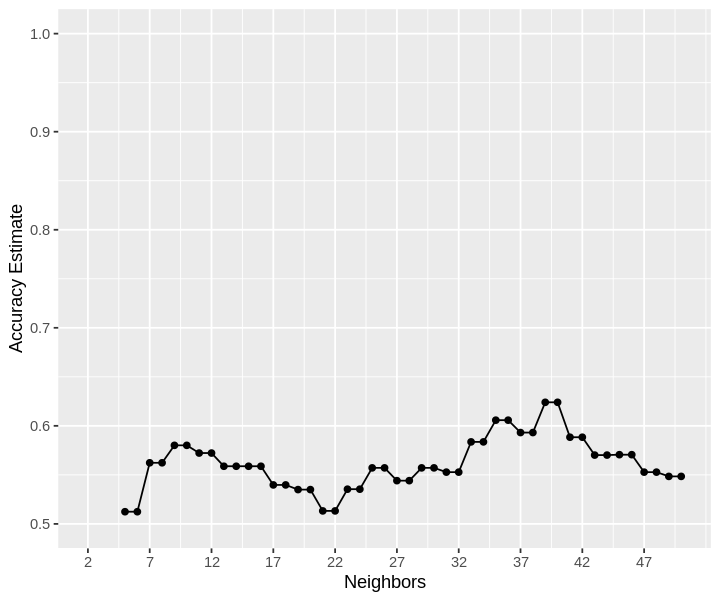

In [7]:
set.seed(88)
options(repr.plot.height = 5, repr.plot.width = 6)

cd_recipe <- recipe(cp ~ ., data = cd_training)|>
            step_scale(all_predictors())|>
            step_center(all_predictors()) 
           

cd_vfold <- vfold_cv(cd_training, v = 10, strata = cp)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

k = tibble(neighbors = seq(2,50,1))

knn_results <- workflow() |>
      add_recipe(cd_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = cd_vfold, grid = k) |>
      collect_metrics()

accuracies <- knn_results |> 
      filter(.metric == "accuracy")

accuracies
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(2, 50, by = 5)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.5, 1.0)) # adjusting the y-axis


cross_val_plot

In [13]:
set.seed(88)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 39) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(cd_recipe) |>
  add_model(knn_spec) |>
  fit(data = cd_training)

cd_test_predictions <- predict(knn_fit, cd_testing) |>
  bind_cols(cd_testing)

cd_test_predictions |>
  metrics(truth = cp, estimate = .pred_class) |>
  filter(.metric == "accuracy")

confusion <- cd_test_predictions |>
             conf_mat(truth = cp, estimate = .pred_class)
confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5333333


          Truth
Prediction  0  1
         0 17 16
         1 19 23

## References

Carson, J. (n.d.). 2019 ACC/AHA guideline on the primary prevention of ... - circulation. Retrieved April 8, 
2023, from https://www.ahajournals.org/doi/full/10.1161/CIR.0000000000000677

Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J.-J., Sandhu, S., Guppy, K. H., 
Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm 
for the diagnosis of coronary artery disease. The American Journal of Cardiology, 64(5), 
304–310. https://doi.org/10.1016/0002-9149(89)90524-9 

Electrocardiogram. (n.d.). Retrieved April 8, 2023, from 
https://www.heartandstroke.ca/heart-disease/tests/electrocardiogram

Rodgers, J., Jones, J., Bolleddu, S., Vanthenapalli, S., Rodgers, L., Shah, K., . . . Panguluri, S. (2019, 
April 27). Cardiovascular risks associated with gender and aging. Retrieved April 8, 2023, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6616540/

Wu, C., Hu, H., Chou, Y., Huang, N., Chou, Y., & Li, C. (2015, November). High blood pressure 
and all-cause and cardiovascular disease mortalities in community-dwelling older adults. Retrieved April 8, 2023, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5059018/
